In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.cluster import hierarchy
from functools import reduce
import json

In [2]:
full_data=pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [3]:
full_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [10]:
# for mydate in ['2020-12-31','2021-12-31']:
covid2 = full_data[full_data['date']=='2021-12-31']
covid3 = covid2[['location','total_cases_per_million','new_cases_per_million',
                   'total_deaths_per_million','new_deaths_per_million',
                   'reproduction_rate','positive_rate','total_tests_per_thousand',
                 'icu_patients_per_million','hosp_patients_per_million']].dropna()
covid_data = covid3.drop(columns='location')
countries = covid3['location'].tolist()

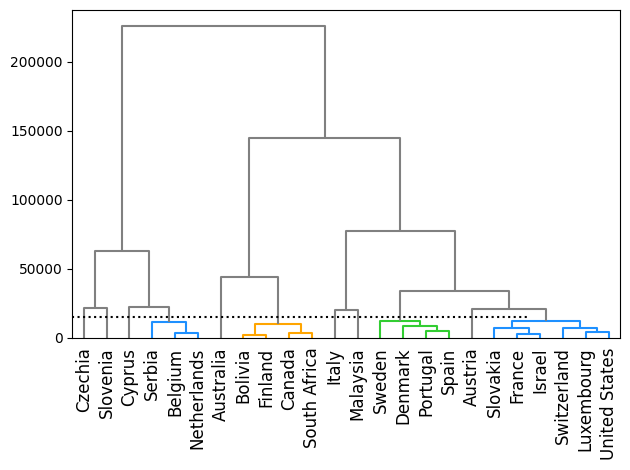

In [11]:
clusters = hierarchy.linkage(covid_data,metric='euclidean',method='complete')

cut_height = 15000

# Set the colour palette to be used in the dendrogram.
colour1 = 'dodgerblue'
colour2 = 'orange'
colour3 = 'limegreen'
hierarchy.set_link_color_palette([colour1, colour2, colour3])

hierarchy.dendrogram(clusters,
                    labels=countries,
                    leaf_rotation=90,
                    leaf_font_size=12,
                    color_threshold=cut_height,
                    above_threshold_color='grey')
plt.tight_layout()
plt.plot((0,200),(cut_height,cut_height),color='black',linestyle=':')
# plt.savefig('M06 Fig10.jpg')
plt.show()

In [12]:
clusters = hierarchy.linkage(covid_data,metric='euclidean',method='complete')
T = hierarchy.to_tree( clusters , rd=False )
labels=countries
id2name = dict(zip(range(len(labels)), labels))
def add_node(node, parent ):
	# First create the new node and append it to its parent's children
	newNode = dict( node_id=node.id, children=[] )
	parent["children"].append( newNode )

	# Recursively add the current node's children
	if node.left: add_node( node.left, newNode )
	if node.right: add_node( node.right, newNode )

# Initialize nested dictionary for d3, then recursively iterate through tree
d3Dendro = dict(children=[], name="Root1")
add_node( T, d3Dendro )

# Label each node with the names of each leaf in its subtree
def label_tree( n ):
	# If the node is a leaf, then we have its name
	if len(n["children"]) == 0:
		leafNames = [ id2name[n["node_id"]] ]
	
	# If not, flatten all the leaves in the node's subtree
	else:
		leafNames = reduce(lambda ls, c: ls + label_tree(c), n["children"], [])

	# Delete the node id since we don't need it anymore and
	# it makes for cleaner JSON
	del n["node_id"]

	# Labeling convention: "-"-separated leaf names
	n["name"] = name = "-".join(sorted(map(str, leafNames)))
	
	return leafNames

label_tree( d3Dendro["children"][0] )

# Output to JSON
json.dump(d3Dendro, open("d3-dendrogram_2021.json", "w"), sort_keys=True, indent=4)